# Setting Up

In [6]:
! pip install pydub


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
#importing Libraries
import pandas as pd
import numpy as np
import torch
import librosa, librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset

/usr/local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [8]:
# importing data
iemocap_df = pd.read_csv('/kaggle/input/iemocap-transcriptions-english-french/iemocapTrans.csv')

In [9]:
iemocap_df.head()

,_id,activation,dominance,emotion,end_time,start_time,titre,to_translate,translated,valence
0,625682441da7a5c1eaef3689,2.5,3.5,sad,6.0541,3.9987,Ses02M_impro02_F000,I don't want you to go.,Je ne veux pas que tu partes.,2.5
1,625682441da7a5c1eaef368a,3.0,4.0,sad,15.1000,7.0366,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",Je sais je sais. Je ne veux pas y aller non pl...,2.0
2,625682441da7a5c1eaef368b,2.5,4.5,sad,23.3599,15.5524,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,Tu vas me manquer aussi; Je ne sais pas ce que...,1.5
3,625682441da7a5c1eaef368c,2.5,4.0,sad,26.4151,23.5790,Ses02M_impro02_F002,I don't want to be a single mom.,Je ne veux pas être une mère célibataire.,1.5
4,625682441da7a5c1eaef368d,3.0,3.5,sad,31.4253,26.7598,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,Vous ne le serez pas. Je reviendrai; Je serai ...,3.5


In [10]:
# selecting columns - emotion, end_time, start_time, titre
iemocap_df = iemocap_df.loc[:,['emotion', 'titre', 'end_time', 'start_time']]

In [11]:
iemocap_df.head()

,emotion,titre,end_time,start_time
0,sad,Ses02M_impro02_F000,6.0541,3.9987
1,sad,Ses02M_impro02_M000,15.1000,7.0366
2,sad,Ses02M_impro02_F001,23.3599,15.5524
3,sad,Ses02M_impro02_F002,26.4151,23.5790
4,sad,Ses02M_impro02_M001,31.4253,26.7598


In [12]:
# adding the filepath to the dataframe
location = '/kaggle/input/iemocap-transcriptions-english-french/Iemocap_audio/iemocap_audio/IEMOCAP_wav/'

iemocap_df['filepath'] = location + iemocap_df['titre'] + '.wav'

In [13]:
iemocap_df.head()

,emotion,titre,end_time,start_time,filepath
0,sad,Ses02M_impro02_F000,6.0541,3.9987,/kaggle/input/iemocap-transcriptions-english-f...
1,sad,Ses02M_impro02_M000,15.1000,7.0366,/kaggle/input/iemocap-transcriptions-english-f...
2,sad,Ses02M_impro02_F001,23.3599,15.5524,/kaggle/input/iemocap-transcriptions-english-f...
3,sad,Ses02M_impro02_F002,26.4151,23.5790,/kaggle/input/iemocap-transcriptions-english-f...
4,sad,Ses02M_impro02_M001,31.4253,26.7598,/kaggle/input/iemocap-transcriptions-english-f...


# Data Preprocessing

In [14]:
def show_cat(df):
    print('sad', df.emotion.loc[df.emotion == 'sad'].count())
    print('fru', df.emotion.loc[df.emotion == 'fru'].count())
    print('neu', df.emotion.loc[df.emotion == 'neu'].count())
    print('hap', df.emotion.loc[df.emotion == 'hap'].count())
    print('exc', df.emotion.loc[df.emotion == 'exc'].count())
    print('sur', df.emotion.loc[df.emotion == 'sur'].count())
    print('ang', df.emotion.loc[df.emotion == 'ang'].count())
    print('fea', df.emotion.loc[df.emotion == 'fea'].count())
    print('oth', df.emotion.loc[df.emotion == 'oth'].count())
    print('dis', df.emotion.loc[df.emotion == 'dis'].count())

In [15]:
show_cat(iemocap_df)

sad 1250
fru 2917
neu 1726
hap 656
exc 1976
sur 110
ang 1269
fea 107
oth 26
dis 2


In [16]:
def length_fixing(sample):
    
    # each input is defined to have a 1s (1000ms) length
    segment_length = 3000
    temp_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    audio_file_path = sample['filepath']
    file_name = sample['titre']
    # print(file_name, audio_file_path)
    # loading audio using AudioSegment
    audio = AudioSegment.from_file(audio_file_path, format="wav")
    # print(len(audio))
    if len(audio) < 3000:
        padding = AudioSegment.silent(duration=(segment_length - len(audio)))
        audio += padding
        # print(len(audio))
        audio.export("/kaggle/working/"+ file_name +"segment_1.wav", format="wav")
        new_record ={
                'emotion':[sample['emotion']],
                'titre' : [file_name + "segment_1"],
                'filepath' : ["/kaggle/working/"+ file_name +"segment_1.wav"]
            }
        return pd.concat([temp_df, pd.DataFrame(new_record)], ignore_index=True)    
    
    segments = [audio[i:i+segment_length] for i in range(0, len(audio), segment_length)]
    
    temp_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    # padding the last segment to match the fixed length
    last_seg_len = len(segments[-1])
    if last_seg_len > 2500:
        padding = AudioSegment.silent(duration=(segment_length - last_seg_len))
        segments[-1] += padding
    else:
        segments = segments[:-1]
    # print(len(segments[-1]))
    for i,segment in enumerate(segments):
            segment.export("/kaggle/working/"+ file_name +f"segment_{i}.wav", format="wav")
            new_record ={
                'emotion':[sample['emotion']],
                'titre' : [file_name +f"segment_{i}"],
                'filepath' : ["/kaggle/working/"+ file_name +f"segment_{i}.wav"]
            }
            temp_df = pd.concat([temp_df, pd.DataFrame(new_record)], ignore_index=True)    
    return temp_df

In [17]:
iemocap_df_seg = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    
for _, row in iemocap_df.iterrows():
    temp_df = length_fixing(row)
    iemocap_df_seg = pd.concat([iemocap_df_seg, temp_df], ignore_index=True)    

In [18]:
show_cat(iemocap_df_seg)

sad 2073
fru 4156
neu 2239
hap 900
exc 2823
sur 127
ang 1809
fea 128
oth 33
dis 2


In [19]:
# selecting th efollowing emotion categories for the prediction
emotions = ['sad', 'fru', 'neu', 'hap', 'exc', 'ang']

In [20]:
iemocap_df_seg = iemocap_df_seg.loc[iemocap_df_seg['emotion'].isin(emotions)]

In [21]:
show_cat(iemocap_df_seg)

sad 2073
fru 4156
neu 2239
hap 900
exc 2823
sur 0
ang 1809
fea 0
oth 0
dis 0


## Train Test split

In [22]:
# train : val = 0.7:0.3
# 630 samples : 270 samples

In [23]:
train_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in emotions:
    train_df = pd.concat([train_df, pd.DataFrame(iemocap_df_seg[iemocap_df_seg['emotion']==emotion].sample(630))], axis =0, ignore_index=True)
train_df.shape

(3780, 3)

In [24]:
test_df = iemocap_df_seg.merge(train_df, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
test_df.shape

(10220, 3)

In [25]:
val_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in emotions:
    val_df = pd.concat([val_df, pd.DataFrame(test_df[test_df['emotion']==emotion].sample(270))], axis =0, ignore_index=True)
val_df.shape

(1620, 3)

## Mel Spectrogram

In [ ]:
def extract_features(dataset):
    
    temp_feature_list = []
    temp_label_list = []
    
    # loop through th erows of dataframe
    
    for _, row in dataset.iterrows():
        
        file_path = row['filepath']
        label = row['emotion']
        #print('filepath:', file_path)
        #print('label:', label)
        # loading the audion file
        audio, sr = librosa.load(file_path, sr=44100)
        if len(audio) < sr*3:
            audio = librosa.util.pad_center(audio, size=sr*3)
        # print(len(audio))
        MFCCs = librosa.feature.mfcc(y=audio[:sr*3],sr=sr, n_fft=1024,hop_length=128,n_mfcc=128)
        #print(MFCCs_.shape)
        # log spectro of the MFCCs
        MFCCs_ = librosa.amplitude_to_db(MFCCs)
        temp_feature_list.append(MFCCs_)
        temp_label_list.append(label)
        
    return np.array(temp_feature_list), np.array(temp_label_list)

In [ ]:
X_train, Y_train = extract_features(train_df)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_val, Y_val = extract_features(val_df)

In [ ]:
X_val.shape, Y_val.shape

## Creating DataLoaders

In [33]:
# converting the target class into one-hot-encoded vectors
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

Y_train_lb = lb.fit_transform(Y_train)
Y_val_lb = lb.fit_transform(Y_val)

NameError: name 'Y_train' is not defined

In [ ]:
Y_val_lb

In [ ]:
Y_train_lb.shape, Y_val_lb.shape

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train_lb, dtype=torch.float32)
X_test = torch.tensor(X_val, dtype=torch.float32)
Y_test = torch.tensor(Y_val_lb, dtype=torch.float32)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=64)

# Model Building

## Model_1
LSTM Architecture

In [ ]:
import torch
import torch.nn as nn

# Define the model class
class CustomLSTMModel(nn.Module):
    def __init__(self):
        super(CustomLSTMModel, self).__init__()
        
        # Define the layers
        self.lstm = nn.LSTM(input_size= 1034, hidden_size= 512, num_layers=1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.4)
        #self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 64)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        #self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(64, 6)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Define the forward pass
        out, _ = self.lstm(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        #out = self.fc1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        #out = self.fc3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

## Model_2
CNN Architecture

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # output - 128x1034
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)# 64x517
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1) # 64x517
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,3), stride=(2,4))# 32 x 129
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1) # 32 x 129
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2,3), stride=2)# 16x64
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1) # 16x64
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)# 8x32
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 32, 1024)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 128)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        #print(x.shape)
        #print(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.fc3(x)
        
        return x

## Model_3
Fine Tuning VGG 16 model

In [26]:
import torchvision.models as models

# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 267MB/s] 


In [27]:
# freezing the convolutional layers
# fully connected layers are to be fine tuned
for param in vgg_model.features.parameters():
    param.requires_grad = False

In [28]:
vgg_model.classifier[6] = torch.nn.Linear(vgg_model.classifier[6].in_features, 6)

## Training and Eval Functions

In [29]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for batch in iterator:
        src, trg = batch
        # src= src.unsqueeze(0) # 1- CNN
        #print(src.shape)
        optimizer.zero_grad()
        output = model(src)
        # output = torch.mean(output, axis = 1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

In [30]:
def evaluate(model, iterator, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src, trg = batch 
            #src= src.unsqueeze(0) # 1- CNN
            output = model(src)
            #output = torch.mean(output, axis = 1)
            loss = criterion(output, trg)
            total_loss += loss.item()
    return total_loss / len(iterator)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
def calculate_accuracy(model, data_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      predicted_labels = []
      true_labels = []
      for data in data_loader:
          inputs, labels = data
          #inputs = inputs.unsqueeze(0)# 1- CNN
          output = model(inputs)
          #print(output.shape)
          #output = torch.mean(output, axis = 1)
          #print(output)
          max_index = (torch.argmax(output,dim =1).view(-1)).numpy()
          #print("max: ",len(max_index))
          true_label = (torch.argmax(labels,dim =1).view(-1)).numpy()
          #print("true:" ,len(true_label))
          predicted_labels.extend(max_index)
          true_labels.extend(true_label)
  #print(predicted_labels[:-30])
  #print(len(true_labels))
  accuracy = accuracy_score(true_labels, predicted_labels)
  print('Confusion_matrix: ',confusion_matrix(true_labels, predicted_labels))
  return accuracy

# Training

## Model_1

In [ ]:
# Create an instance of the model
model_1 = CustomLSTMModel()

# Print the model summary
print(model_1)

In [ ]:
# defining the optimizers and loss functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

In [ ]:
# Training model_1
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train(model_1, train_loader, optimizer, criterion)
    val_loss = evaluate(model_1, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

In [ ]:
# Calculate accuracy on the validation set
train_accuracy = calculate_accuracy(model_1, train_loader)

val_accuracy = calculate_accuracy(model_1, val_loader)

In [ ]:
train_accuracy, val_accuracy

## Model_2

In [ ]:
# Create an instance of the model
model_2 =  SimpleCNN(6)

# Print the model summary
print(model_2)

In [37]:
# defining the optimizers and loss functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)

In [38]:
# Training model_1
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train(model_2, train_loader, optimizer, criterion)
    val_loss = evaluate(model_2, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.784
Epoch: 02
	Validation Loss: 1.786
Epoch: 03
	Validation Loss: 1.747
Epoch: 04
	Validation Loss: 1.722
Epoch: 05
	Validation Loss: 1.665


In [39]:
# Calculate accuracy on the validation set
train_accuracy = calculate_accuracy(model_2, train_loader)

val_accuracy = calculate_accuracy(model_2, val_loader)

Confusion_matrix:  [[298 137  44  10  43  98]
 [111 226  25   8  55 205]
 [110 171  61   9  61 218]
 [ 90 179  43  17  55 246]
 [ 34 155  44   7 100 290]
 [ 20  58  15   3  34 500]]
Confusion_matrix:  [[115  77  18   1  14  45]
 [ 50  87  13   3  36  81]
 [ 45  78  22   9  30  86]
 [ 33  80  17   5  20 115]
 [ 16  67  16   2  38 131]
 [ 18  20   9   1  15 207]]


In [40]:
train_accuracy, val_accuracy

(0.317989417989418, 0.29259259259259257)

In [41]:
model_2_temp = model_2

In [42]:
# train for more epochs
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train(model_2_temp, train_loader, optimizer, criterion)
    val_loss = evaluate(model_2_temp, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.628
Epoch: 02
	Validation Loss: 1.674
Epoch: 03
	Validation Loss: 1.610
Epoch: 04
	Validation Loss: 1.618
Epoch: 05
	Validation Loss: 1.605


In [44]:
# Calculate accuracy on the validation set
train_accuracy_1 = calculate_accuracy(model_2_temp, train_loader)

val_accuracy_1 = calculate_accuracy(model_2_temp, val_loader)

Confusion_matrix:  [[396  38  69  14  68  45]
 [150 132  61  29 167  91]
 [139  54 122  17 173 125]
 [122  63  52  55 162 176]
 [ 27  59  38  11 305 190]
 [ 24  13  21   5  79 488]]
Confusion_matrix:  [[153  15  31   6  46  19]
 [ 65  42  27  14  77  45]
 [ 58  30  36  14  82  50]
 [ 42  35  30   9  77  77]
 [ 14  35  23   6 114  78]
 [ 14   4  19   0  50 183]]


In [45]:
train_accuracy_1, val_accuracy_1

(0.3962962962962963, 0.3314814814814815)

In [46]:
# further train for 5  more epochs
model_2_temp_2 = model_2_temp
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train(model_2_temp_2, train_loader, optimizer, criterion)
    val_loss = evaluate(model_2_temp_2, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.711
Epoch: 02
	Validation Loss: 1.829


KeyboardInterrupt: 

In [47]:
# Calculate accuracy on the validation set
train_accuracy_2 = calculate_accuracy(model_2_temp_2, train_loader)
val_accuracy_2 = calculate_accuracy(model_2_temp_2, val_loader)

Confusion_matrix:  [[ 32  27  45 384  27 115]
 [  3  28  17 321  34 227]
 [  0  11  58 241  49 271]
 [  1   4   6 305  26 288]
 [  0   4  10 156 103 357]
 [  0   2   5  40  12 571]]
Confusion_matrix:  [[ 12   9  15 157  10  67]
 [  1  10  10 116  30 103]
 [  0   7   9 119  22 113]
 [  1   3   5 112  12 137]
 [  0   4   5  76  25 160]
 [  0   0   4  25   7 234]]


In [48]:
train_accuracy_2, val_accuracy_2

(0.2902116402116402, 0.24814814814814815)

## Model_3

In [32]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

Creating the input dataset in the format 224,224,3

sad


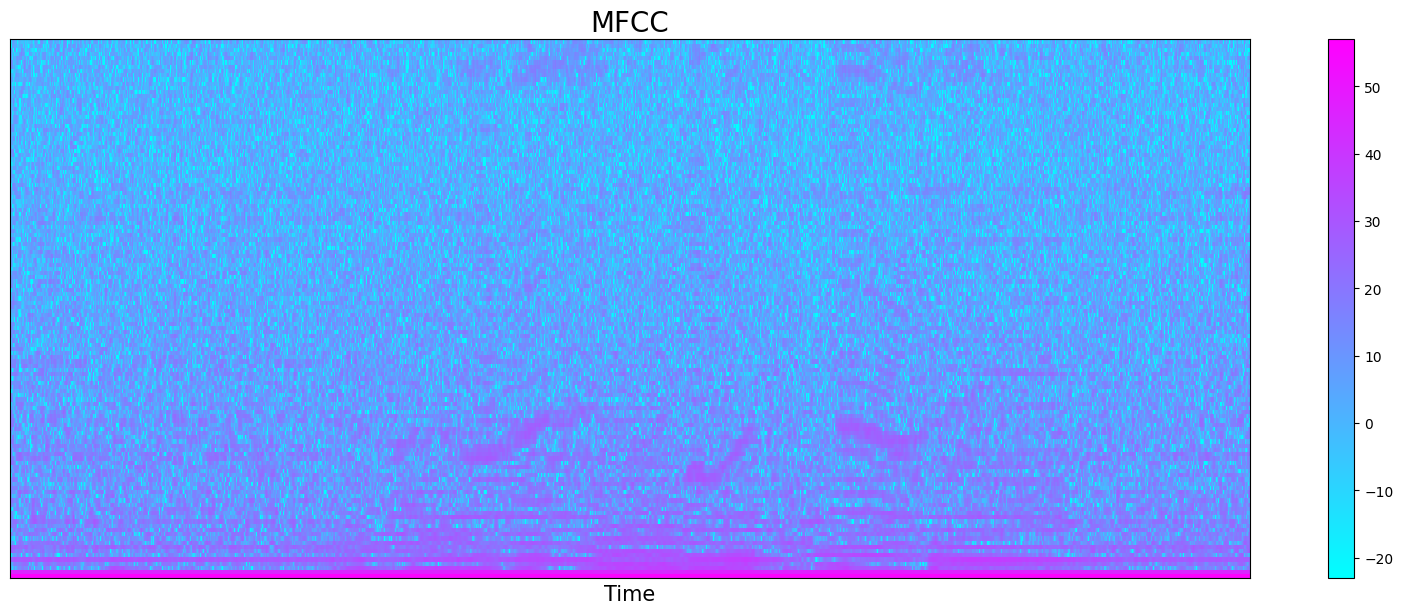

In [88]:
hop_length = 128 #the default spacing between frames
n_fft = 1024 #number of samples 
#cut the sample to the relevant times
i= 555
y, sr = librosa.load(train_df['filepath'].iloc[i], sr=50150)
print(train_df['emotion'].iloc[i])
MFCCs = librosa.feature.mfcc(y=y,sr=sr, n_fft=n_fft,hop_length=128,n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(librosa.amplitude_to_db(MFCCs),sr=sr, cmap='cool',hop_length=128)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [95]:
MFCCs = MFCCs.reshape(224,224,3)
MFCCs.shape

(224, 224, 3)

In [33]:
def extract_features_VGG(dataset):
    
    temp_feature_list = []
    temp_label_list = []
    
    # loop through th erows of dataframe
    
    for _, row in dataset.iterrows():
        
        file_path = row['filepath']
        label = row['emotion']
        #print('filepath:', file_path)
        #print('label:', label)
        # loading the audion file
        audio, sr = librosa.load(file_path, sr=50150)
        if len(audio) < sr*3:
            audio = librosa.util.pad_center(audio, size=sr*3)
        # print(len(audio))
        MFCCs = librosa.feature.mfcc(y=audio[:sr*3],sr=sr, n_fft=1024,hop_length=128,n_mfcc=128)
        #print(MFCCs_.shape)
        # log spectro of the MFCCs
        MFCCs_ = librosa.amplitude_to_db(MFCCs)
        temp_feature_list.append(MFCCs_.reshape(3,224,224))
        temp_label_list.append(label)
        
    return np.array(temp_feature_list), np.array(temp_label_list)

In [34]:
X_train_vgg, Y_train_vgg = extract_features_VGG(train_df)

In [35]:
X_train_vgg.shape, Y_train_vgg.shape

((3780, 3, 224, 224), (3780,))

In [36]:
X_val_vgg, Y_val_vgg = extract_features_VGG(val_df)

In [37]:
X_val_vgg.shape, Y_val_vgg.shape

((1620, 3, 224, 224), (1620,))

In [38]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [39]:
Y_train_lb_vgg = lb.fit_transform(Y_train_vgg)
Y_val_lb_vgg = lb.fit_transform(Y_val_vgg)

In [40]:
X_train = torch.tensor(X_train_vgg, dtype=torch.float32)
Y_train = torch.tensor(Y_train_lb_vgg, dtype=torch.float32)
X_test = torch.tensor(X_val_vgg, dtype=torch.float32)
Y_test = torch.tensor(Y_val_lb_vgg, dtype=torch.float32)

In [41]:
train_loader_vgg = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader_vgg = DataLoader(TensorDataset(X_test, Y_test), batch_size=64)

In [42]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train(vgg_model, train_loader_vgg, optimizer, criterion)
    val_loss = evaluate(vgg_model, val_loader_vgg, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.757
Epoch: 02
	Validation Loss: 1.727
Epoch: 03
	Validation Loss: 1.722
Epoch: 04
	Validation Loss: 1.719
Epoch: 05
	Validation Loss: 1.712
Epoch: 06
	Validation Loss: 1.712
Epoch: 07
	Validation Loss: 1.702
Epoch: 08
	Validation Loss: 1.692
Epoch: 09
	Validation Loss: 1.692
Epoch: 10
	Validation Loss: 1.697


In [43]:
# Calculate accuracy on the validation set
train_accuracy_vgg = calculate_accuracy(vgg_model, train_loader_vgg)
val_accuracy_vgg = calculate_accuracy(vgg_model, val_loader_vgg)

Confusion_matrix:  [[248  96 192   3  27  64]
 [118 105 229   1  55 122]
 [110  66 265   4  49 136]
 [100  79 194   5  67 185]
 [ 46  81 189   2 120 192]
 [ 12  25 122   2  52 417]]
Confusion_matrix:  [[112  31  79   0  15  33]
 [ 53  45  89   3  27  53]
 [ 49  40  97   1  23  60]
 [ 33  33  89   1  32  82]
 [ 12  34  85   3  53  83]
 [ 14  14  55   0  27 160]]


In [44]:
train_accuracy_vgg, val_accuracy_vgg

(0.30687830687830686, 0.28888888888888886)

In [47]:
# further train for 10 more epochs

In [48]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train(vgg_model, train_loader_vgg, optimizer, criterion)
    val_loss = evaluate(vgg_model, val_loader_vgg, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.714
Epoch: 02
	Validation Loss: 1.712
Epoch: 03
	Validation Loss: 1.708
Epoch: 04
	Validation Loss: 1.692
Epoch: 05
	Validation Loss: 1.687
Epoch: 06
	Validation Loss: 1.695
Epoch: 07
	Validation Loss: 1.695
Epoch: 08
	Validation Loss: 1.701
Epoch: 09
	Validation Loss: 1.684
Epoch: 10
	Validation Loss: 1.690


In [49]:
# Calculate accuracy on the validation set
train_accuracy_vgg = calculate_accuracy(vgg_model, train_loader_vgg)
val_accuracy_vgg = calculate_accuracy(vgg_model, val_loader_vgg)

Confusion_matrix:  [[291  95 109  18  38  79]
 [122 180  72  23  65 168]
 [111  98 153  34  63 171]
 [108  96  82  52  56 236]
 [ 61  92  73  32 129 243]
 [ 17  32  40  22  39 480]]
Confusion_matrix:  [[107  36  59  12  12  44]
 [ 58  55  42  13  34  68]
 [ 59  39  47  14  24  87]
 [ 39  51  30  16  34 100]
 [ 27  41  31  31  35 105]
 [ 17  17  23  12  25 176]]


In [50]:
train_accuracy_vgg, val_accuracy_vgg

(0.33994708994708994, 0.2691358024691358)

In [51]:
# train 10 more epochs
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train(vgg_model, train_loader_vgg, optimizer, criterion)
    val_loss = evaluate(vgg_model, val_loader_vgg, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.698
Epoch: 02
	Validation Loss: 1.681
Epoch: 03
	Validation Loss: 1.690
Epoch: 04
	Validation Loss: 1.687
Epoch: 05
	Validation Loss: 1.704


KeyboardInterrupt: 

In [ ]:
# Calculate accuracy on the validation set
train_accuracy_vgg = calculate_accuracy(vgg_model, train_loader_vgg)
val_accuracy_vgg = calculate_accuracy(vgg_model, val_loader_vgg)

In [ ]:
train_accuracy_vgg, val_accuracy_vgg

# Saving the trained models

In [49]:
import pickle
# saving models in both .pkl and .pth formats

## LSTM Model

In [50]:
# saving LSTM Model-->Model_1
# Specify the file path where you want to save the model
model_path_1 = '/kaggle/working/LSTM_1735_1747.pth'

# Save the model's state dictionary to the specified file
torch.save(model_1, model_path_1)


NameError: name 'model_1' is not defined

In [ ]:
model_path_1 = '/kaggle/working/LSTM_1735_1747.pkl'

# Serialize and save the model to the .pkl file
with open(model_path_1, 'wb') as file:
    pickle.dump(model_1, file)

In [ ]:
torch.save(model_1, '/kaggle/working/LSTM_1735_1747.h5')

## CNN Models

In [51]:
model_path_2 = '/kaggle/working/CNN_3180_2926.pth'

# Save the model's state dictionary to the specified file
torch.save(model_2, model_path_2)

In [52]:
model_path_2 = '/kaggle/working/CNN_3180_2926.pkl'

# Serialize and save the model to the .pkl file
with open(model_path_2, 'wb') as file:
    pickle.dump(model_2, file)

In [53]:
torch.save(model_2, '/kaggle/working/CNN_3180_2926.h5')

In [54]:
model_path_2 = '/kaggle/working/CNN_3963_3315.pth'

# Save the model's state dictionary to the specified file
torch.save(model_2_temp, model_path_2)

In [55]:
model_path_2 = '/kaggle/working/CNN_3963_3315.pkl'

# Serialize and save the model to the .pkl file
with open(model_path_2, 'wb') as file:
    pickle.dump(model_2_temp, file)

In [56]:
torch.save(model_2_temp, '/kaggle/working/CNN_3963_3315.h5')

## VGG Model 

In [45]:
model_path = '/kaggle/working/VGG.pth'

# Save the model's state dictionary to the specified file
torch.save(vgg_model, model_path)

In [46]:
model_path = '/kaggle/working/VGG.pkl'

# Serialize and save the model to the .pkl file
with open(model_path, 'wb') as file:
    pickle.dump(vgg_model, file)

NameError: name 'pickle' is not defined

In [ ]:
torch.save(vgg_model, '/kaggle/working/VGG.h5')

# Reference

* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
* https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990